In [243]:
#!pip install contractions
import os
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
#import tensorflow as tf


nltk.download("stopwords")
nltk.download("punkt")

#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)
project_path = os.getcwd()
#project_path = os.path.join('drive', 'MyDrive', "emailos")
#import sys
#sys.path.append(project_path)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\IK\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\IK\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Data Preparation

#### Read data file

In [244]:
import pandas as pd

datafile = os.path.join(project_path, "data.csv")

dataset = pd.read_csv(datafile)

dataset.head()

,Review,Sentiment,Rating,Age,Gender,Location
0,This product is amazing! ...,Positive,5,28,Male,New York
1,I'm extremely satisfied with my purchase. ...,Positive,4,35,Female,London
2,The quality of this product exceeded my expec...,Positive,5,42,Male,Los Angeles
3,It's a waste of money. ...,Negative,1,31,Female,Paris
4,The customer service was terrible. ...,Negative,2,45,Male,Berlin


#### Data Exploration

#### Statistics of numerical features in the dataset

In [245]:
dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
Rating,20.00,3.10,1.52,1.00,2.00,3.00,4.25,5.00
Age,20.00,33.10,5.95,23.00,28.75,32.50,37.25,45.00


<Axes: xlabel='Rating', ylabel='count'>

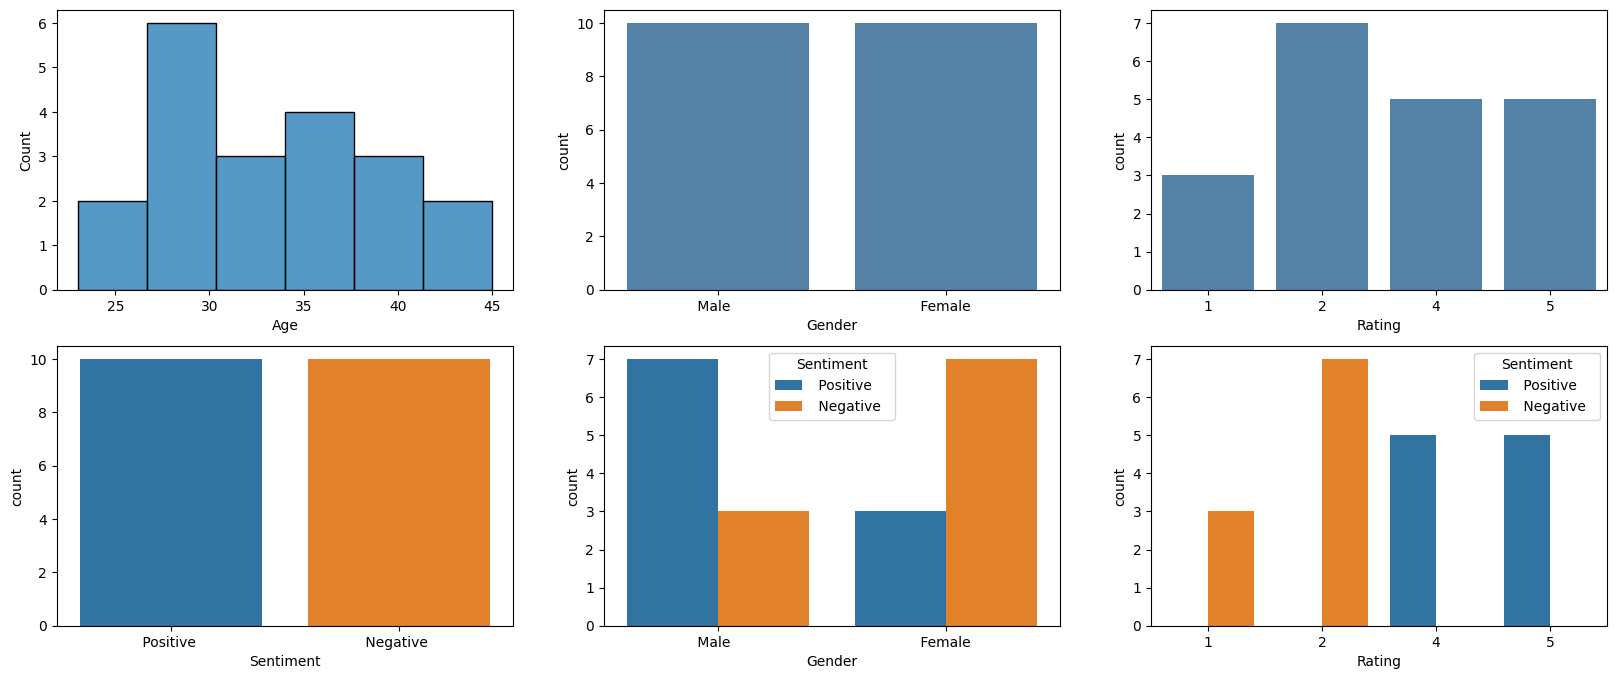

In [246]:
fig1, (row1, row2) = plt.subplots(nrows=2, ncols=3, figsize=(20, 8))

sns.histplot(data=dataset, x="Age", ax=row1[0])

sns.countplot(data=dataset, x="Gender", ax=row1[1], color="steelblue")

sns.countplot(data=dataset, x="Rating", ax=row1[2], color="steelblue")

sns.countplot(data=dataset, x="Sentiment", ax=row2[0])

sns.countplot(data=dataset, x="Gender", hue="Sentiment", ax=row2[1])

sns.countplot(data=dataset, x="Rating", hue="Sentiment", ax=row2[2])

#### Inference
- There are equal number of male and female reviewers
- Most of the products are rated 2 out of 5
- There are equal number of products with positive and negative sentiments
- Most of th positive sentiments are given by men. Women give more negative reviews
- All reviews on products with rating of 2 or lower have negative sentiment and product with rating greater than or equal to 4 have positive sentiment.

#### Term Frequency Analysis

Text(0.5, 1.0, 'Top 15 Negative terms')

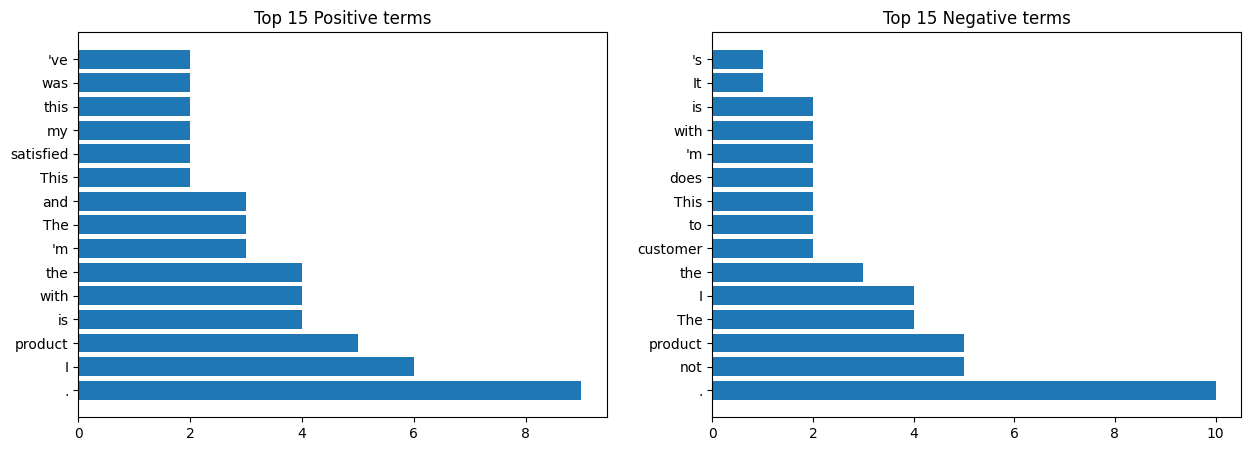

In [247]:
from collections import Counter
from nltk.tokenize import word_tokenize


def token_frequency(texts):
    terms = []

    for text in texts:
        tokens = word_tokenize(text)
        terms.extend(tokens)

    term_freq_dist = Counter(terms)
    term_freq_dist = dict(
        sorted(term_freq_dist.items(), reverse=True, key=lambda x: x[1])
    )
    terms = list(term_freq_dist.keys())
    freqs = list(term_freq_dist.values())
    return terms, freqs


n = 15


dataset["Sentiment"] = dataset["Sentiment"].apply(lambda x: x.strip())


positive_reviews = dataset.query("Sentiment == 'Positive'").Review.tolist()
positive_terms, positive_terms_freq = token_frequency(positive_reviews)


negative_reviews = dataset.query("Sentiment == 'Negative'").Review.tolist()
negative_terms, negative_terms_freq = token_frequency(negative_reviews)


fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# create bar plots
ax1.barh(positive_terms[:n], positive_terms_freq[:n])
ax1.set_title(f"Top {n} Positive terms")

ax2.barh(negative_terms[:n], negative_terms_freq[:n])
ax2.set_title(f"Top {n} Negative terms")

From our initial term frequency analysis, we can see some meaningful terms like `product`, `satisfied`, `not`. We can also see many stopwords.

Data preprocessing will be carried out on the review column

#### Preprocess dataset

##### _Convert Sentiment column to binary_

In [248]:
from text_preprocessing import convert_sentiment_to_integer

dataset["Binary_sentiment"] = dataset["Sentiment"].apply(
    lambda sentiment: convert_sentiment_to_integer(sentiment)
)
dataset.head()

,Review,Sentiment,Rating,Age,Gender,Location,Binary_sentiment
0,This product is amazing! ...,Positive,5,28,Male,New York,1
1,I'm extremely satisfied with my purchase. ...,Positive,4,35,Female,London,1
2,The quality of this product exceeded my expec...,Positive,5,42,Male,Los Angeles,1
3,It's a waste of money. ...,Negative,1,31,Female,Paris,0
4,The customer service was terrible. ...,Negative,2,45,Male,Berlin,0


##### _Process review column_

In [249]:
from text_preprocessing import TextPreprocessor

dataset_obj = dataset.select_dtypes(['object'])
dataset[dataset_obj.columns] = dataset[dataset_obj.columns].apply(lambda x: x.str.strip())


review_preprocessor = TextPreprocessor()
exclude_from_stopwords = ["not"]


dataset["Processed_review"] = dataset["Review"].apply(
    lambda review: review_preprocessor.process_text(
        review, exclude_stopwords=exclude_from_stopwords
    )
)

dataset.head()

,Review,Sentiment,Rating,Age,Gender,Location,Binary_sentiment,Processed_review
0,This product is amazing!,Positive,5,28,Male,New York,1,product amazing
1,I'm extremely satisfied with my purchase.,Positive,4,35,Female,London,1,extremely satisfied purchase
2,The quality of this product exceeded my expect...,Positive,5,42,Male,Los Angeles,1,quality product exceed expectation
3,It's a waste of money.,Negative,1,31,Female,Paris,0,waste money
4,The customer service was terrible.,Negative,2,45,Male,Berlin,0,customer service terrible


#### Term Frequency analysis 2

Text(0.5, 1.0, 'Top 15 terms in processed negative reviews')

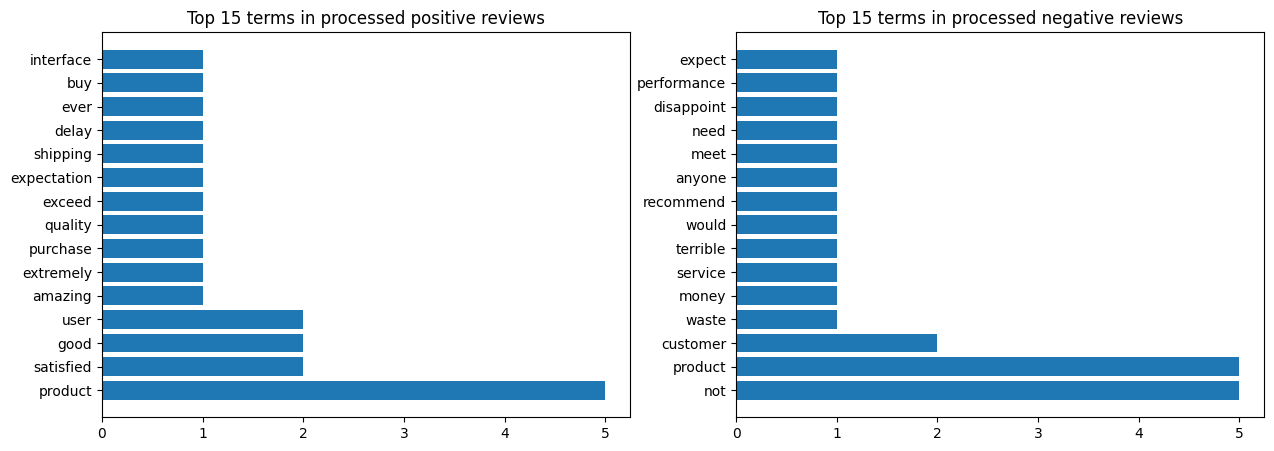

In [250]:
positive_reviews = dataset.query("Binary_sentiment == 1").Processed_review.tolist()
positive_terms, positive_terms_freq = token_frequency(positive_reviews)


negative_reviews = dataset.query("Binary_sentiment == 0").Processed_review.tolist()
negative_terms, negative_terms_freq = token_frequency(negative_reviews)


fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# create bar plots
ax1.barh(positive_terms[:n], positive_terms_freq[:n])
ax1.set_title(f"Top {n} terms in processed positive reviews")

ax2.barh(negative_terms[:n], negative_terms_freq[:n])
ax2.set_title(f"Top {n} terms in processed negative reviews")

Term frequency analysis after processing the reviews give more meaningful terms

### Text Representations

#### Extract and transform features and sentiments

In [251]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer


# selected features from dataset
selected_features = dataset[["Processed_review", "Rating", "Gender"]]

# categorical columns
cat_cols = ["Rating", "Gender"]

# product review column
review_col = "Processed_review"

# one hot encoding config for Rating and Gender column
one_hot_encoded = OneHotEncoder(categories=[[1,2,3,4,5], ["Male", "Female"]])

# tfidf for text column
tfidf_vec = TfidfVectorizer()

# column transformer for both features
transformer = ColumnTransformer(
  [
      ('review_preprocess', tfidf_vec, review_col),
      ('cat_cols', one_hot_encoded, cat_cols)
  ]
)

# fit transform features
features = transformer.fit_transform(selected_features).toarray()

# extract labels
labels = dataset.Binary_sentiment.tolist()

features.shape, len(labels)

((20, 56), 20)

#### Split features and labels into train and test sets

In [252]:
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.2, random_state=22, stratify=labels)

### Machine learning Classifiers

In [253]:
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score



def multiple_models_analysis(train_features, train_labels, test_features, test_labels):
  """
  Analyze multiple machine learning models using various metrics.

  Args:
      train_features: Training data features.
      train_labels: Training data labels.
      test_features: Test data features.
      test_labels: Test data labels.

  Returns:
      A tuple containing a DataFrame with model results and a dictionary of model instances.
  """
  models = {}
  accuracy, precision, recall, f1 = {}, {}, {}, {}

  # Create instances of various machine learning models
  models['Logistic Regression'] = LogisticRegression()
  models['Support Vector Machines'] = SVC()
  models['Naive Bayes'] = GaussianNB()
  models['K-Nearest Neighbor'] = KNeighborsClassifier()

  # Iterate over models and analyze their performance
  for model_name, model_instance in models.items():
      model_instance.fit(train_features, train_labels)
      predictions = model_instance.predict(test_features)

      accuracy[model_name] = accuracy_score(test_labels, predictions)
      precision[model_name] = precision_score(test_labels, predictions)
      recall[model_name] = recall_score(test_labels, predictions)
      f1[model_name] = f1_score(test_labels, predictions)

  # Create a DataFrame to store the results
  model_results = pd.DataFrame(
      index=models.keys(),
      columns=['Accuracy', 'Precision', 'Recall', 'F1_score']
  )
  model_results['Accuracy'] = accuracy.values()
  model_results['Precision'] = precision.values()
  model_results['Recall'] = recall.values()
  model_results['F1_score'] = f1.values()

  return model_results, models


#### Model analysis using TFIDF representation



In [254]:
tfidf_model_results, tfidf_models = multiple_models_analysis(
    train_features, train_labels, test_features, test_labels
)
tfidf_model_results

,Accuracy,Precision,Recall,F1_score
Logistic Regression,1.00,1.00,1.00,1.00
Support Vector Machines,1.00,1.00,1.00,1.00
Naive Bayes,1.00,1.00,1.00,1.00
K-Nearest Neighbor,0.50,0.50,0.50,0.50


 Logistic Regression, SVM and Naive bayes all display perfect results

In [255]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import precision_recall_fscore_support


clf1 = LogisticRegression()
clf2 = SVC()
clf3 = GaussianNB()


ensemble_clf = VotingClassifier(
  estimators=[('LR', clf1), ('SVC', clf2), ('GNB', clf3)],
  voting='hard')

ensemble_clf.fit(train_features, train_labels)
ensemble_prediction = ensemble_clf.predict(test_features)
precision_recall_fscore_support(test_labels, ensemble_prediction, average='macro')


(1.0, 1.0, 1.0, None)

### Save Ensemble model and column transformer

In [62]:
from helpers import pickle_python_object

vectorizer_filepath = os.path.join(project_path, "feature_transformer.pkl")
model_filepath = os.path.join(project_path, "ensemble_LR-SVC-GNB_model.pkl")


pickle_python_object(transformer, vectorizer_filepath)
pickle_python_object(ensemble_clf, model_filepath)

True